# Приложение: advanced plotting (you can skip this part)

In [14]:
data = pd.read_csv('/Users/philurame/Downloads/hw_knn/aim-2023-crabs/crabs_train.csv')

- график tsne с градиентным цветом по age и markers по sex $\downarrow$

In [61]:
import openTSNE
import plotly.graph_objects as go

np.random.seed(42)
random_idx = np.random.choice(data.shape[0], size=1000, replace=False)
dataslice = data.iloc[random_idx, :]
X = data.iloc[:, 1:8].values

affinities = openTSNE.affinity.PerplexityBasedNN(X, perplexity=30, k_neighbors=70, n_jobs=-1)
init = openTSNE.initialization.pca(X)
embedding = openTSNE.TSNEEmbedding(init, affinities, dof=0.8, verbose=False)

figures = dict(I='star-diamond', M='cross', F='star')
markers = dict(
  symbol=dataslice['sex'].map(figures), 
  size=9,
  color=dataslice['age'],
  colorscale='thermal', # ylorrd thermal hot RdBu
  )

fig = go.Figure()
for i in range(12): # нужно заранее подготовить все графики, между которыми будет переключаться слайдер
  embedding = embedding.optimize(n_iter=50, exaggeration=12 if i < 5 else 4)
  fig.add_trace(
    go.Scatter(
      x=embedding[random_idx, 0],
      y=embedding[random_idx, 1],
      visible=False,
      mode='markers', # <------- если так не написать, будут линии с точками :)
      marker=markers,
      marker_line=dict(width=0.2, color='black'),
    )
  )

    
# Блок с шагами такой же, как и выше - "стандартный"
######
steps = []
for i in range(len(fig.data)):
  # каждый step - шаг слайдера = какое-то изменение аргументов data / layout
  step = {
    'method': 'restyle', # меняем только data
    'args': [
        {'visible': [False] * len(fig.data)}, # data args
    ],
    'label': 'iter:' + str((i + 1) * 50) # подписи внизу слайдера
  }
  step['args'][0]['visible'][i] = True # делаем i-й график видимым
  steps.append(step)
    
    
start_age_idx = 0
fig.data[start_age_idx].visible = True

sliders = [{
  'active': start_age_idx,
  'steps': steps,
  'currentvalue': {'prefix': 'iter: '}
}]
#####

fig.update_layout(sliders=sliders, title='Scatter Plot with Color Bar',
  xaxis_title='X-axis', yaxis_title='Y-axis',coloraxis_colorbar=)

fig.show()

- so beautifull yet so random...
- плюс = M, звездочка = F, diamond = I; темнее = младше

- - - 

- графики umap для фиксированного sex=SPLITBY и градиентом по age $\downarrow$

In [113]:
SPLITBY = 'F'

import umap
from bokeh.io import output_notebook
output_notebook()

from bokeh.plotting import figure, show
from bokeh.models import ColumnDataSource, ColorMapper, LinearColorMapper, ColorBar
from bokeh.palettes import Inferno

dataS = data[data.sex == SPLITBY]

embedding_1 = umap.UMAP(n_neighbors=7, metric='l1', n_jobs=-1).fit_transform(dataS.iloc[:, 1:8].values)
embedding_2 = umap.UMAP(n_neighbors=7, metric='canberra', n_jobs=-1).fit_transform(dataS.iloc[:, 1:8].values)

random_idx = np.random.choice(dataS.shape[0], replace=False, size=10_000)

color_mapper = LinearColorMapper(palette=Inferno[256], low=data.age.min(), high=data.age.max())

source = ColumnDataSource({
  'l1_x': embedding_1[random_idx, 0],
  'l1_y': embedding_1[random_idx, 1],
  'canberra_x': embedding_2[random_idx, 0],
  'canberra_y': embedding_2[random_idx, 1],
  'age': dataS.age.values[random_idx]
})

tools = ['box_select', 'lasso_select', 'reset', 'box_zoom']

fig_1 = figure(tools=tools, width=400, height=400, title=f'sex={SPLITBY}, metric=l1')
fig_1.circle(
  source=source,
  x='l1_x', y='l1_y',
  color=dict(field='age', 
             transform=color_mapper,
             ),
)

fig_2 = figure(tools=tools, width=500, height=400, title=f'sex={SPLITBY}, metric=canberra')
fig_2.circle(
  source=source,
  x='canberra_x', y='canberra_y', 
  color=dict(field='age', 
             transform=color_mapper,
             ),
)

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, location=(0, 0), title='age')
fig_2.add_layout(color_bar, 'right')

from bokeh.layouts import gridplot
grid = gridplot([[fig_1, fig_2]])

show(grid)

Loading BokehJS ...

- очевидных инсайтов вроде бы не наблюдается, но судя по этому графику я хотя бы более уверен в метрике `l1` для Female, так как график менее непрерывный
- возможно было бы неплохо построить такие графики для множества подмножеств из признаков и сгенерированных признаков

# В общих чертах:

$~$

$~$
что я сделал:
1) немного нормализовал данные и таргет
2) для каждого `sex` сделал отдельный knn предсказывающий target
3) просто перебрал оптуной `n_neighbors`, `metric`

$~$

$~$
что не сработало:
1) использовать metric_learn (NCA, MLKR и др.) тк во-первых большинство из них для классификации и маленького набора данных, работают слишком долго, да и разультат почти такой же (+ с ними невозможно использовать оптуну!)
2) PCA делает только хуже, несмотря на то, что explained_variance_ratio_ = 0.999 уже у первых двух компонентах
3) придуманные `new_ftrs` не оказали никакого результата на MAE_VAL. возможно с ними нужно было сделать более полный анализ

$~$

$~$
что улучшило MAE_VAL:
1) разделение модели на 3 в зависимости от `sex`. actually, я даже не пробовал делать модель без разделения, но по распределениям видно, что очевидно так нужно делать
2) нормализация таргета с помощью `log1p`

$~$

$~$
не тестил:
1) придумать свою нелинейную метрику
2) #! предсказывать метки используя медиану, а не mean!
3) #! разбить признаки на группы и на них делать knn (потом объединить линейно/...) 

In [294]:
# import all
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
from optuna.samplers import TPESampler
from optuna.visualization import plot_slice
import matplotlib as mpl
mpl.rcParams['legend.title_fontsize'] = 13
mpl.rcParams['legend.fontsize'] = 13
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_numeric_dtype


# load data
df_tr = pd.read_csv('aim-2023-crabs/crabs_train.csv')
df_tst = pd.read_csv('aim-2023-crabs/crabs_test.csv')

# get rid of strings
df_tr['sex']  = df_tr['sex'].map({'M': -1, 'F': 1, 'I': 0})
df_tst['sex'] = df_tst['sex'].map({'M': -1, 'F': 1, 'I': 0})

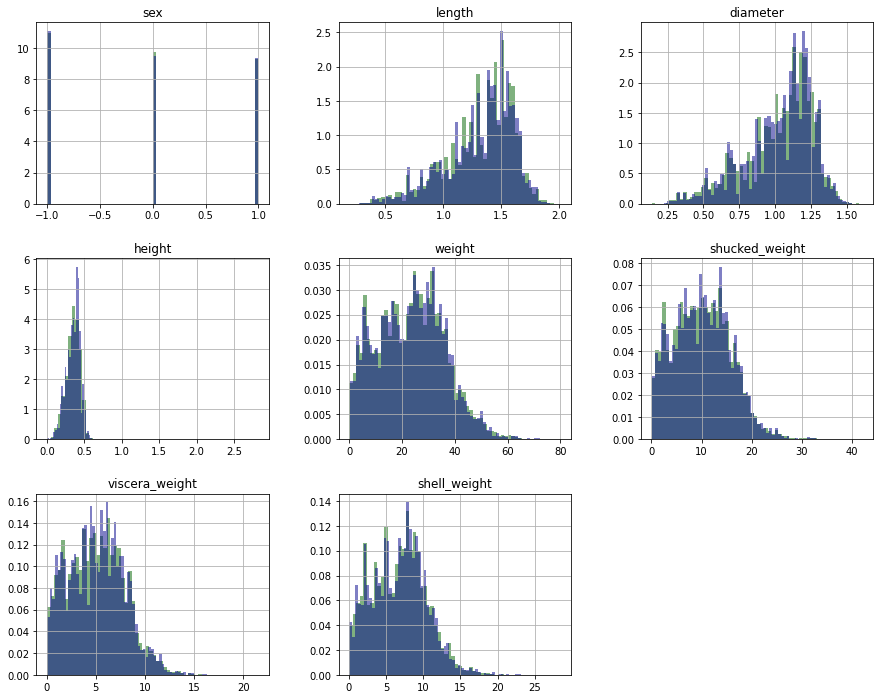

In [295]:
# check distribution on train and test
ax = df_tr.drop(columns=['age']).hist(bins=60, figsize=(15, 12), color='darkgreen', alpha=0.5, density=True)
df_tst.hist(bins=60, ax=ax.ravel()[:-1], color='darkblue', alpha=0.5, density=True);

- распределение выглядит стационарным, так что если на трейне сработает то и на тесте должно...
- height кажется с outliers и еще явно с skew, так что может быть полезно его нормализовать

In [292]:
class PlotDensity:
  '''
  Выводит инфу о колонках датафрейма в виде датафрейма
  
  df: 
    исходный датафрейм
  
  # инфа:
  ex1:
    рандомный элемент 
  ex2:
    рандомный элемент отличный от ex1
  vc_max:
    мода и ее частота ее встречаемости
  trash_score:
    max[#nans+#zeros+#empty_str, vcmax.частота*(vcmax.частота>thr)]
  unique, nan, zero, empty_str:
    количество различных/нанов/0/пустых строк

  returns: pd.DataFrame с инфой
  '''
  def __init__(self, df):
    self.df   = df
    self.hue  = None
    self.cols_numeric = []
    self.cols_category = [] 

    self.bins = 25
    self.max_cat_thr = min(len(df)*0.05, 30)
    self.drop_zero     = False
    self.drop_outliers = True
    self.eps_zero      = 1e-4
    self.mypalette = ["#F72585", "#4361EE", "#3A0CA3", "#7209B7", "#4CC9F0"]

  def _divideCols(self): pass
  def _fltrZero(self, df, col): pass
  def _fltrOutliers(self, df, col, lq, rq): pass
  def _dfTransform(self, T, col): pass
    
  def plot_density(self, hue, cols=None):
    '''
    Рисует распределения колонок cols

    cols: отрисовываемые колонки. Если None, то рисуем df.columns (кроме hue)
    hue:  опорная колонка относительно которой идет сравнение на рисунках
    побочные атрибуты указаны в классе
    '''
    self.hue  = hue
    self._divideCols(cols if cols!=None else self.df.columns)
    hue_order = self.df[self.hue].unique()
    palette   = self.mypalette[:len(hue_order)] if len(hue_order)<=5 else sns.color_palette("husl", len(hue_order))

    # numerical first
    for col in self.cols_numeric:
      fig, ax = plt.subplot_mosaic('abc', figsize=(12, 4))
      fig.suptitle(f"[{col}] by [{self.hue}]", fontsize=20, color=self.mypalette[2])
      fig.tight_layout()

      # df_Z and df_O are preprocessed df
      df_Z = self._dfTransform('Z', col)
      df_O = self._dfTransform('O', col)
      if not is_numeric_dtype(self.df[self.hue]):
        df_Z = df_Z.fillna({self.hue:'<NaN>'}).replace({self.hue:('', '<EMPTY>')}).copy()
        df_Z = df_O.fillna({self.hue:'<NaN>'}).replace({self.hue:('', '<EMPTY>')}).copy()

      # histogram
      sns.histplot(data=df_O, x=col, hue=self.hue, hue_order=hue_order, ax=ax['a'],
                   bins=self.bins, multiple='stack', element='step', stat='count', alpha=0.8, palette=palette)
      
      # boxenplot & stripplot
      sns.boxenplot(data=self.df, y=col, hue=self.hue, x=self.hue, hue_order=hue_order,
                    ax=ax['b'], showfliers=False, legend=False, palette=palette)
      sns.stripplot(data=df_O.groupby(self.hue).apply(lambda x: x.sample(n=200) if x.shape[0]>=200 else x), y=col, x=self.hue,
                    hue_order=hue_order, ax=ax['b'], color='black', size=4, legend=False)
      
      # barplot with nan and 0 counting
      eps_zero = min(self.eps_zero, self.df[col].median()*self.eps_zero)
      df_z = (abs(self.df[col])<eps_zero).groupby(self.df[self.hue]).mean().\
        rename('count').reset_index().assign(what='0')
      df_n = self.df[col].isna().groupby(self.df[self.hue]).mean().\
        rename('count').reset_index().assign(what='NaN')
      df_spec = pd.concat([df_n, df_z]).reset_index(drop=True)
      df_spec['count'] = df_spec['count'].replace(0, -.1*df_spec['count'].max())
      if np.all(df_spec['count']<eps_zero): 
        df_spec['count'] = -eps_zero
        ax['c'].set_ylim(-2*eps_zero, 10*eps_zero)
      sns.barplot(data=df_spec, x='what', y='count', hue=self.hue, hue_order=hue_order,\
                  ax=ax['c'], edgecolor='black', legend=False, palette=palette)
      
      # better layout settings
      for i in ax: 
        ax[i].set_ylabel(''), ax[i].tick_params('y', labelsize=12)
        ax[i].set_xlabel(''), ax[i].tick_params('x', rotation=45, labelsize=15)
      ax['a'].set_ylabel('count', fontsize=20)
      ax['a'].tick_params('x', rotation=0, labelsize=12)
      ax['c'].axhline(0, color='black', ls='--')
      ax['c'].grid(True, axis='y')

      plt.show()
      print('#'*113)

    ################################################################################
    # categorial columns
    for col in self.cols_category:
      fig, ax = plt.subplots(figsize=(12, 4))
      fig.suptitle(f"[{col}] by [{self.hue}]", fontsize=20, color=self.mypalette[0])
      fig.tight_layout()

      # countplot using data with filled nans end empty strings
      sns.countplot(data=self._dfTransform('S'), x=col, hue=self.hue, hue_order=hue_order,\
                    ax=ax, stat='count', edgecolor='black', width=0.5, palette=palette)

      # better layout settings
      ax.tick_params('x', rotation=45, labelsize=15)
      ax.tick_params('y', labelsize=12)
      ax.set_ylabel('count', fontsize=20)
      ax.set_xlabel('')
      ax.grid(True, axis='y')
      
      plt.show()
      print('#'*113 if col!=self.cols_category[-1] else '')

  ################################################################################
  ################################################################################
  def _divideCols(self, cols):
    '''
    divides columns into numerical ones and categorical ones
    using is_numeric_dtype and max_cat_thr
    '''
    self.cols_numeric, self.cols_category = [], []
    for col in [i for i in cols if i!=self.hue]:
      if (nonique:=self.df[col].nunique())>=self.max_cat_thr and is_numeric_dtype(self.df[col]):
        self.cols_numeric.append(col)
      elif nonique<self.max_cat_thr:
        self.cols_category.append(col)
    return True

  def _fltrZero(self, df, col):
    '''
    returns df with rows where col has no zeroes if drop_zero == True
    '''
    eps_zero = min(self.eps_zero, df[col].median()*self.eps_zero)
    return df[abs(df[col])<eps_zero] if self.drop_zero else df
  
  def _fltrOutliers(self, df, col, lq=0.01, rq=0.99): 
    '''
    returns df with rows where col less than lq quantile and bigger than rq if drop_outliers == True
    '''
    if self.drop_outliers: 
      return df[(df[col].quantile(lq) < df[col]) &\
                (df[col].quantile(rq) > df[col])]
    return df
  
  def _dfTransform(self, T, col=None):
    '''
    applies fltrZero/fltrOutliers/fltrString depending on T
    '''
    match T:
      case 'S':
        return self.df.fillna('<NaN>').replace('', '<EMPTY>')
      case 'Z':
        return self._fltrZero(self.df, col)
      case 'O':
        return self._fltrZero(self._fltrOutliers(self.df, col), col)

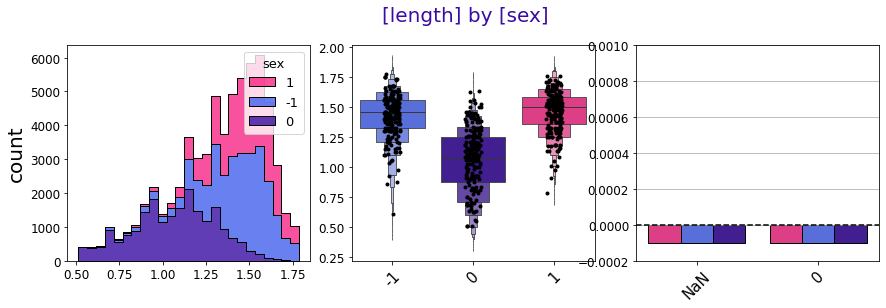

#################################################################################################################


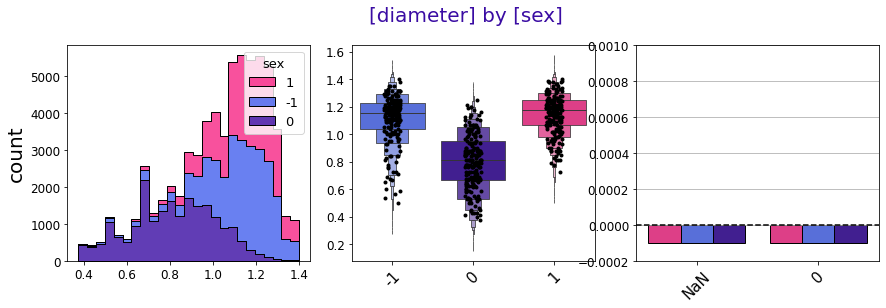

#################################################################################################################


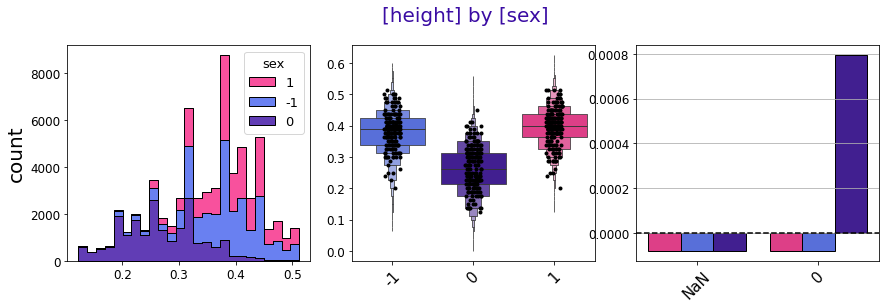

#################################################################################################################


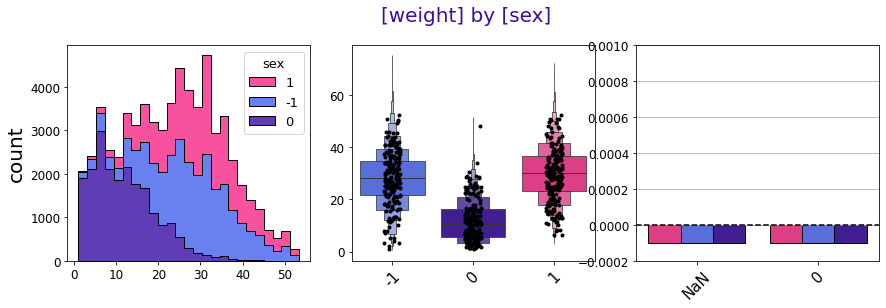

#################################################################################################################


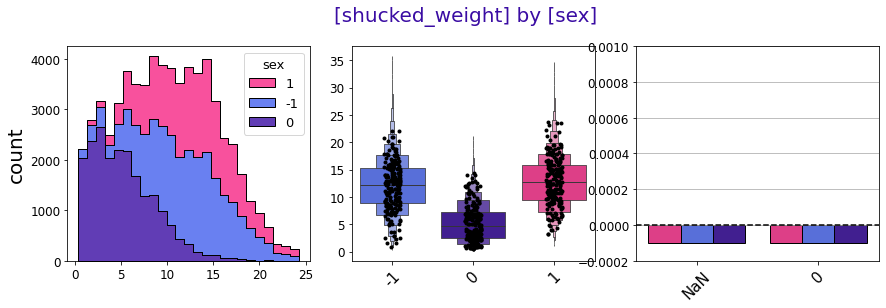

#################################################################################################################


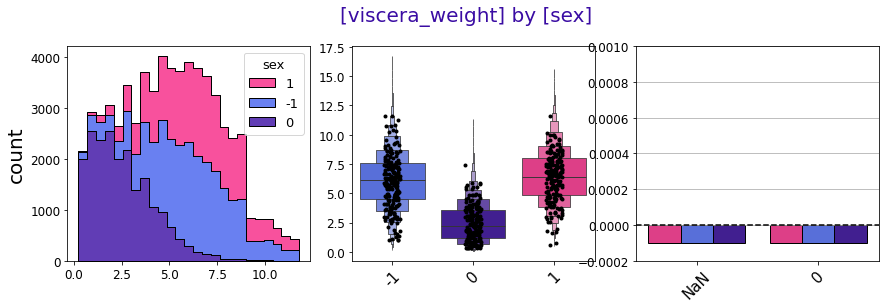

#################################################################################################################


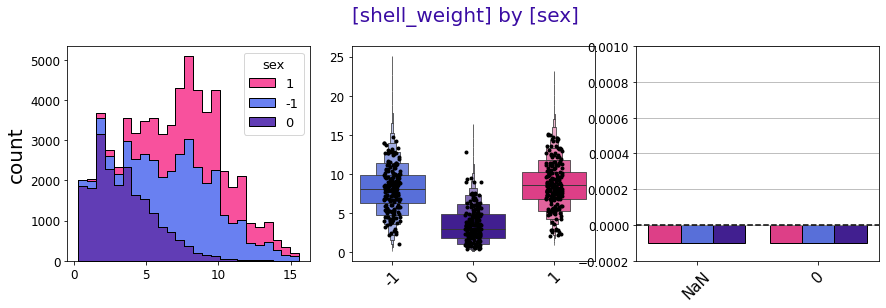

#################################################################################################################


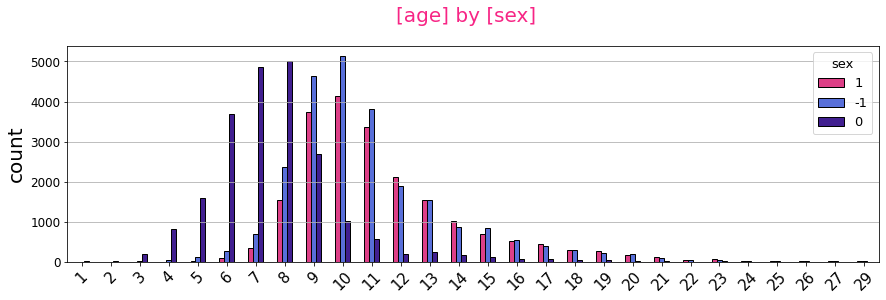

In [293]:
# посмотрим на распредедение признаков в зависимости от sex
PlotDensity(df_tr).plot_density(hue='sex')

- по графикам очевидно, что распределение всех фичей (и таргета - `age`) сильно зависит от параметра `sex`, поэтому просто сделаем 3 модели для каждого `sex`.

# Подбор оптимальных параметров

In [136]:
# ячейка со всеми нужными функциями

def preproc(X_old):
  '''
  нормализует колонку height с np.log1p и обрезает с двух сторон все колонки под 0.001 квантиль
  '''
  X = X_old.copy()
  X['height'] = np.log1p(X['height'])
  X = X.apply(lambda x: x.clip(lower = x.quantile(0.001), upper = x.quantile(0.999)))
  return X

def new_ftrs(df_prev):
  '''
  создает признаки-дроби для тех пар, у которых распределение выглядит одинаково
  также создает признак BMI - индекс массы тела краба
  '''
  df = df_prev.copy()
  df['LenDivDiam'] = df['length'] / df['diameter']

  df['WgtDivVisWgt'] = df['weight'] / df['viscera_weight']
  df['WgtDivVisWgt'] = df['WgtDivVisWgt'].clip(0, df['WgtDivVisWgt'].quantile(0.99))

  df['WgtDivShWgt'] = df['weight'] / df['shell_weight']
  df['WgtDivShWgt'] = df['WgtDivShWgt'].clip(0, df['WgtDivShWgt'].quantile(0.99))

  df['WgtDivShckWgt'] = df['weight'] / df['shucked_weight']
  df['WgtDivShckWgt'] = df['WgtDivShckWgt'].clip(0, df['WgtDivShckWgt'].quantile(0.99))

  df['BMI'] = (df['weight'] / (df['height']**2))
  df['BMI'] = df['BMI'].clip(0, df['BMI'].quantile(0.99))
  return df

def tr_val_tst_split(df_tr, df_tst, target_col, splitby='sex', ratio=0.8, seed=42, isTestTarget=False):
  '''
  разбивает df_tr и df_tst по признаку sex, после чего случайно разбивает 
  df_tr на X_tr, X_val в соотношении ratio.
  
  returns: dict with 3 keys-dicts: 
  tr={gender: (X_tr, y_tr)}, val={gender: (X_val, y_val)}, tst={gender: (X_tst, y_tst)}
  '''
  np.random.seed(seed)
  splitvals = df_tr[splitby].unique()
  dict_split = {'tr': {}, 'val': {}, 'tst': {}}
  for s in splitvals:
    X_tr = df_tr[df_tr[splitby]==s].drop(columns=[target_col, splitby])
    y_tr = df_tr[df_tr[splitby]==s].drop(columns=splitby)[target_col]
    X_tst = df_tst[df_tst[splitby]==s].drop(columns=[target_col,splitby], errors='ignore')
    y_tst = None if not isTestTarget else df_tst[df_tst[splitby]==s].drop(columns=splitby)[target_col]
   
    tr = np.random.choice(X_tr.shape[0], int(X_tr.shape[0]*ratio), replace=False)
    val = np.setdiff1d(range(X_tr.shape[0]), tr)
    dict_split['tr'][s]  = (X_tr.iloc[tr], y_tr.iloc[tr])
    dict_split['val'][s] = (X_tr.iloc[val], y_tr.iloc[val])
    dict_split['tst'][s] = (X_tst, y_tst)

    dict_split['tr']['id'] = tr
    dict_split['val']['id'] = val
  return dict_split

def knn_pred(X_tr, y_tr, X_val, **params):
  '''
  обучает knn regression на (X_tr, y_tr) и выдает предсказания на X_val.
  если параметр isNewFtrs==True, то делает новые признаки с помошью new_ftrs

  для обучения нормализует таргет с np.log1p, 
  после чего восстанавливает предсказания с помощью np.exp()-1

  returns knn-predictions
  '''
  metric = params['metric']
  n_neighbors = params['n_neighbors']
  # isNewFtrs = params['isNewFtrs']
  # if isNewFtrs:
  #   X_tr1  = new_ftrs(X_tr)
  #   X_val1 = new_ftrs(X_val)
  # else:
  #   X_tr1  = X_tr.copy()
  #   X_val1 = X_val.copy()
  
  X_tr1 = preproc(X_tr.copy())
  X_val1 = preproc(X_val.copy())
  
  knn = KNeighborsRegressor(metric=metric,n_neighbors=n_neighbors)
  knn.fit(X_tr1, np.log1p(y_tr))
  pred = np.exp(knn.predict(X_val1))-1
  return pred

def pipe_optuna(dict_split, gender, **fixed_params):
  '''
  берет словарь полученный с помощью tr_val_tst_split, достает gender и 
  прогоняет optuna study c TPESampler. обучаемые параметры - те, что передаются в knn_pred
  (n_neighbors, metric, isNewFtrs); fixed_params не обучаются.

  returns: study
  '''
  seed = fixed_params.get('seed', 42)
  np.random.seed(seed)

  X_tr, y_tr   = dict_split['tr'][gender][0].copy(),  dict_split['tr'][gender][1].copy()
  X_val, y_val = dict_split['val'][gender][0].copy(), dict_split['val'][gender][1].copy()

  sampler = TPESampler(seed=seed, n_startup_trials=100)

  def objective(trial, X_tr, y_tr, X_val, y_val):
    params = fixed_params.copy()
    if 'n_neighbors' not in params:
      params['n_neighbors'] = trial.suggest_int('n_neighbors', 5, 200)
    if 'metric' not in params:
      params['metric'] = trial.suggest_categorical('metric', ['l1', 'canberra', 'euclidean'])
    # if 'isNewFtrs' not in params:
    #   params['isNewFtrs'] = trial.suggest_categorical('isNewFtrs', [True, False])

    pred = knn_pred(X_tr, y_tr, X_val, **params)
    mae = mean_absolute_error(y_val, np.rint(pred).astype(int))
    return mae

  study = optuna.create_study(direction='minimize', sampler=sampler)
  study.optimize(lambda trial: objective(trial, X_tr, y_tr, X_val, y_val), n_trials=250)
  print(study.best_params)
  return study

## `sex=1` (Female) analysis

In [283]:
GENDER = 1

In [94]:
seed = 42
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER)
plot_slice(study)

{'n_neighbors': 39, 'metric': 'l1'}


In [95]:
seed = 43
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed)
plot_slice(study)

{'n_neighbors': 74, 'metric': 'euclidean'}


In [96]:
seed = 44
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed)
plot_slice(study)

{'n_neighbors': 46, 'metric': 'canberra'}


- возьмем `l1` тк у нее самый лучший MAE, хотя лучше бы стоило сделать больше итераций "кросс-валидации"
- посмотрим на количество `n_neighbors` на спорных seeds

In [285]:
seed = 43
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed, metric='l1')
plot_slice(study)

{'n_neighbors': 47}


In [140]:
seed = 44
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed, metric='l1')
plot_slice(study)

{'n_neighbors': 50}


- в принципе любое число в окрестности лучшего=`50` годится, его и возьмем

## `sex=-1` (Male) analysis

In [124]:
GENDER = -1

In [99]:
seed = 42
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed)
plot_slice(study)

{'n_neighbors': 82, 'metric': 'l1'}


In [100]:
seed = 43
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed)
plot_slice(study)

{'n_neighbors': 90, 'metric': 'l1'}


- `l1` снова победитель, `n_neighbors=90`

## `sex=0` $\text{(I)}$ analysis

In [102]:
GENDER = 0

In [103]:
seed = 42
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed)
plot_slice(study)

{'n_neighbors': 147, 'metric': 'l1'}


In [104]:
seed = 43
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed)
plot_slice(study)

{'n_neighbors': 49, 'metric': 'canberra'}


In [105]:
seed = 44
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', seed=seed)
study = pipe_optuna(dict_split, gender=GENDER, seed=seed)
plot_slice(study)

{'n_neighbors': 65, 'metric': 'canberra'}


- `canberra` явный победитель, `n_neighbors=65`

# Submission

In [289]:
path_submit_predictions = 'submission.csv'

# final params
params = {
  1: {'n_neighbors': 50,  'metric': 'l1',},
  0: {'n_neighbors': 65,  'metric': 'canberra',},
 -1: {'n_neighbors': 90,  'metric': 'l1',},
  }

# use whole training set
dict_split = tr_val_tst_split(df_tr, df_tst, 'age', 'sex', ratio=1)

# submit
for gender in [-1, 0, 1]:
  X_tr, y_tr   = dict_split['tr'][gender][0].copy(), dict_split['tr'][gender][1].copy()
  X_tst, y_tst = dict_split['tst'][gender][0].copy(), None
  pred = knn_pred(X_tr, y_tr, X_tst, **params[gender])
  df_tst.loc[df_tst.sex==gender, 'pred'] = np.rint(pred).astype(int)

df_tst.reset_index()[['index', 'pred']].rename(columns={'index': 'id', 'pred': 'age'}).to_csv(path_submit_predictions, index=False)